In [219]:
import os
import sys
from tqdm import tqdm
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

print(os.getcwd())

import torch
import torch.nn as nn
import torchvision.transforms as T
from model.resnet50_enc_dec_model import ResNetEncDec
from datasets_utils.dataset_class import DynamicMVTecDataset
from datasets_utils.dataset_split import split_dataset
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
import random
from torch.utils.data import Dataset
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/sameerhashmi36/Documents/AVS7/anomaly_detection_computer_vision/mvtec_anomaly_detection_scipt/testing


In [220]:
# Data transform
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

In [221]:
dataset = DynamicMVTecDataset(good_image_dir="../../datasets/mvtec/bottle/train/good/", transform=transform, augmentations=['cutpaste'])
_, val_data = split_dataset(dataset=dataset)

In [222]:
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)

In [223]:

def load_trained_model(checkpoint_path, device):
    """
    Load the trained model from a checkpoint.

    Parameters:
    - checkpoint_path: Path to the saved model checkpoint.
    - device: The device to map the model to.

    Returns:
    - model: The trained model in evaluation mode.
    """
    model = ResNetEncDec().to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

In [224]:
def test_model(model, test_loader, criterion, device):
    """
    Evaluate the model on a test dataset.

    Parameters:
    - model: The trained model.
    - test_loader: DataLoader for the test dataset.
    - criterion: Loss function (e.g., BCE loss).
    - device: The device to perform evaluation on.

    Returns:
    - avg_loss: Average test loss.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks, labels in tqdm(test_loader, desc="Testing"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            decoded, _ = model(images)
            decoded = torch.sigmoid(decoded)

            # Compute loss
            loss = criterion(decoded, masks)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    print(f"Average Test Loss: {avg_loss:.4f}")
    return avg_loss

In [225]:
def visualize_samples(model, test_loader, device, num_samples=10):
    """
    Visualize random samples from the test dataset with predictions and ground truth masks.

    Parameters:
    - model: The trained model.
    - test_loader: DataLoader for the test dataset.
    - device: The device to perform inference on.
    - num_samples: Number of samples to visualize.
    """
    model.eval()
    samples = random.sample(list(test_loader), num_samples)
    # samples_count = 0

    for images, masks, labels in samples:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        with torch.no_grad():
            decoded, _ = model(images)
            decoded = torch.sigmoid(decoded)

        # Convert tensors to numpy arrays
        images = images.cpu().permute(0, 2, 3, 1).numpy()  # Rearrange dimensions for visualization
        decoded = decoded.cpu().squeeze(1).numpy()
        masks = masks.cpu().squeeze(1).numpy()

        # Plot images, predictions, and masks
        for i in range(len(images)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i], cmap='gray')
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(decoded[i], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(masks[i], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            # samples_count += 1
            # if samples_count >= num_samples:
            #     return


In [226]:
# Load trained model
checkpoint_path = "../experiments/experiment_03_bottle_cutpaste_resnet50/checkpoints/model_epoch_82_valloss_0.0158.pth"
model = load_trained_model(checkpoint_path, device)

In [227]:
# Criterion for loss calculation
criterion = nn.BCELoss()

In [228]:
# Test the model
test_model(model, val_loader, criterion, device)

Testing:   0%|          | 0/4 [00:00<?, ?it/s]

Testing: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

Average Test Loss: 0.0297


0.029652633238583803

In [229]:

# Visualize random samples
# visualize_samples(model, val_loader, device, num_samples=1)

In [230]:
class TestingMVTecDataset(Dataset):
    def __init__(self, test_dir, ground_truth_dir, transform=None):
        """
        Custom dataset for testing MVTec data.

        Parameters:
        - test_dir: Path to the test images folder.
        - ground_truth_dir: Path to the ground truth masks folder.
        - transform: Transformations to apply to the test images.
        """
        self.test_dir = test_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.data = []

        # Iterate through all subfolders (broken_large, broken_small, contamination)
        for subfolder in os.listdir(test_dir):
            test_subfolder = os.path.join(test_dir, subfolder)
            gt_subfolder = os.path.join(ground_truth_dir, subfolder)

            if os.path.isdir(test_subfolder) and os.path.isdir(gt_subfolder):
                for img_file in os.listdir(test_subfolder):
                    if img_file.endswith(".png"):
                        test_img_path = os.path.join(test_subfolder, img_file)
                        gt_mask_path = os.path.join(gt_subfolder, img_file.replace(".png", "_mask.png"))
                        
                        # Only add entries where both test image and ground truth mask exist
                        if os.path.isfile(test_img_path) and os.path.isfile(gt_mask_path):
                            self.data.append((test_img_path, gt_mask_path))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        test_img_path, gt_mask_path = self.data[idx]

        # Load test image
        test_image = Image.open(test_img_path).convert("RGB")

        # Load ground truth mask
        ground_truth_mask = Image.open(gt_mask_path).convert("L")  # Grayscale for mask

        # Apply transformations
        if self.transform:
            test_image = self.transform(test_image)
            ground_truth_mask = self.transform(ground_truth_mask)

        return test_image, ground_truth_mask, test_img_path


In [231]:
test_image_dir = "../../datasets/mvtec/bottle/test/"
ground_truth_dir = "../../datasets/mvtec/bottle/ground_truth"

test_dataset = TestingMVTecDataset(test_dir=test_image_dir, ground_truth_dir=ground_truth_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

Number of test samples: 63


In [232]:
for batch in test_loader:
    print("Number of elements in the batch:", len(batch))  # Should print 3
    print("Type of test_image:", type(batch[0]))          # Should be torch.Tensor
    print("Shape of test_image:", batch[0].shape)         # Should have image dimensions
    print("Type of ground_truth_mask:", type(batch[1]))   # Should be torch.Tensor
    print("Shape of ground_truth_mask:", batch[1].shape)  # Should match mask dimensions
    print("Type of test_img_path:", type(batch[2]))       # Should be a string (path)
    print("Example test_img_path:", batch[2])             # Path to the image
    break 

Number of elements in the batch: 3
Type of test_image: <class 'torch.Tensor'>
Shape of test_image: torch.Size([1, 3, 256, 256])
Type of ground_truth_mask: <class 'torch.Tensor'>
Shape of ground_truth_mask: torch.Size([1, 1, 256, 256])
Type of test_img_path: <class 'tuple'>
Example test_img_path: ('../../datasets/mvtec/bottle/test/broken_large/019.png',)


In [233]:
# Test the model
test_model(model, test_loader, criterion, device)

Testing: 100%|██████████| 63/63 [00:04<00:00, 13.67it/s]

Average Test Loss: 0.2300


0.22997955909915388

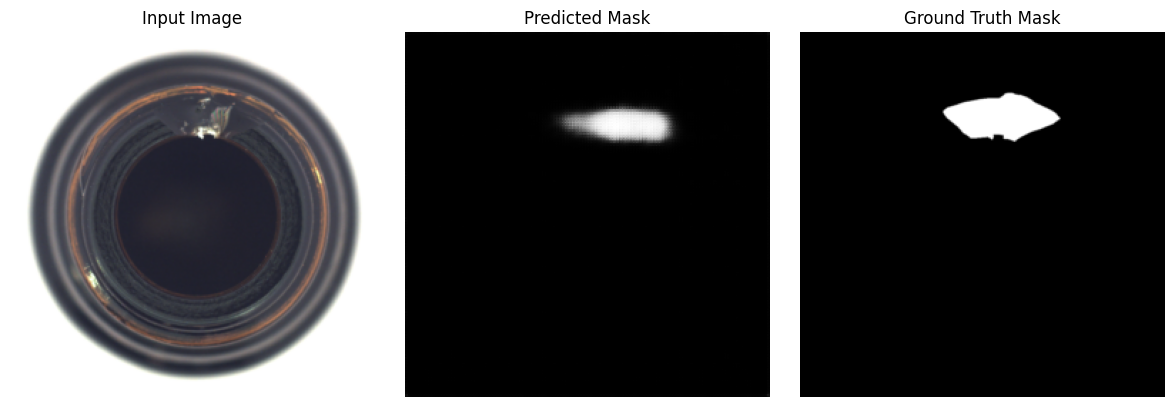

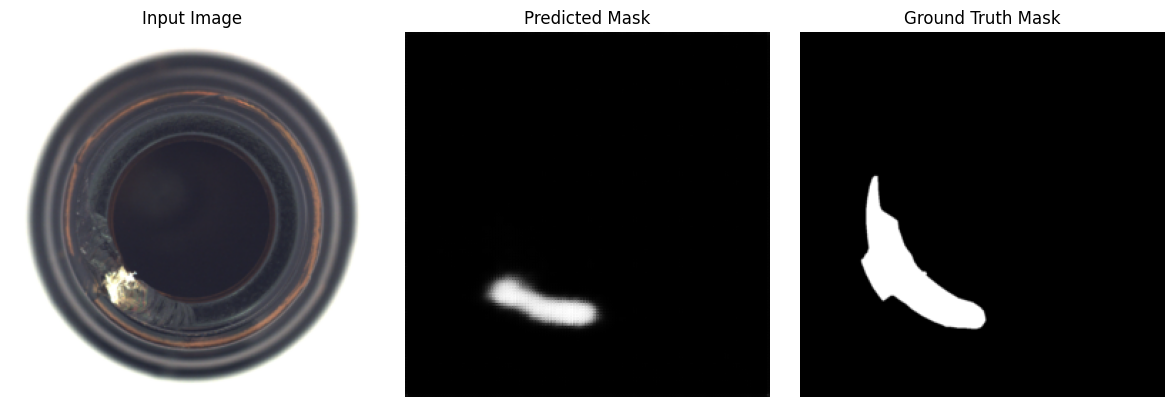

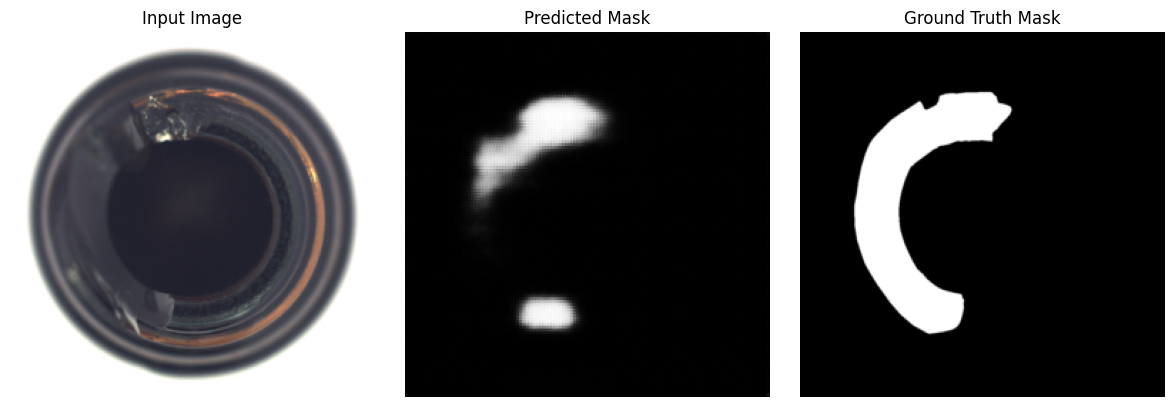

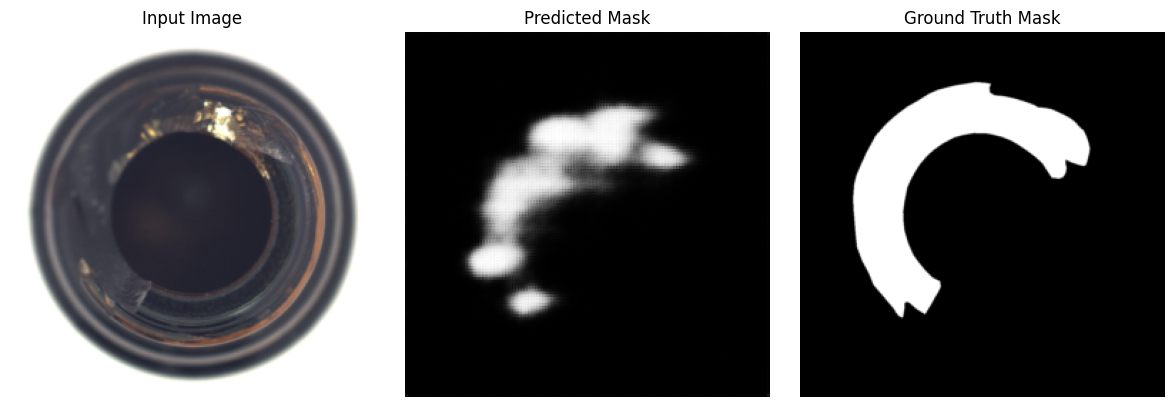

In [241]:
# Visualize random samples
visualize_samples(model, test_loader, device, num_samples=4)

In [235]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve

In [236]:
class TestingMVTecDatasetMatrices(Dataset):
    def __init__(self, test_dir, ground_truth_dir, transform=None):
        """
        Custom dataset for testing MVTec data.

        Parameters:
        - test_dir: Path to the test images folder.
        - ground_truth_dir: Path to the ground truth masks folder.
        - transform: Transformations to apply to the test images.
        """
        self.test_dir = test_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.data = []

        # Iterate through all subfolders (good, broken_large, broken_small, etc.)
        for subfolder in os.listdir(test_dir):
            test_subfolder = os.path.join(test_dir, subfolder)
            gt_subfolder = os.path.join(ground_truth_dir, subfolder) if subfolder != "good" else None

            if os.path.isdir(test_subfolder):
                for img_file in os.listdir(test_subfolder):
                    if img_file.endswith(".png"):
                        test_img_path = os.path.join(test_subfolder, img_file)

                        if subfolder == "good":
                            # For "good" images, generate a dummy mask
                            self.data.append((test_img_path, None, 0))
                        else:
                            gt_mask_path = os.path.join(gt_subfolder, img_file.replace(".png", "_mask.png"))
                            if os.path.isfile(test_img_path) and os.path.isfile(gt_mask_path):
                                self.data.append((test_img_path, gt_mask_path, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        test_img_path, gt_mask_path, label = self.data[idx]

        # Load test image
        test_image = Image.open(test_img_path).convert("RGB")

        # Load ground truth mask or generate dummy mask
        if gt_mask_path is None:  # "good" images
            ground_truth_mask = Image.new("L", (256, 256), color=0)  # Dummy mask of zeros
        else:
            ground_truth_mask = Image.open(gt_mask_path).convert("L")  # Grayscale for mask

        # Apply transformations
        if self.transform:
            test_image = self.transform(test_image)
            ground_truth_mask = self.transform(ground_truth_mask)

        return test_image, ground_truth_mask, label

In [237]:
test_image_dir_1 = "../../datasets/mvtec/bottle/test/"
ground_truth_dir_1 = "../../datasets/mvtec/bottle/ground_truth/"
test_dataset_1 = TestingMVTecDatasetMatrices(test_image_dir_1, ground_truth_dir_1, transform=transform)
test_loader_1 = DataLoader(test_dataset_1, batch_size=1, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

Number of test samples: 63


In [238]:
for batch in test_loader_1:
    print("Number of elements in the batch:", len(batch))  # Should print 3
    print("Type of test_image:", type(batch[0]))          # Should be torch.Tensor
    print("Shape of test_image:", batch[0].shape)         # Should have image dimensions
    print("Type of ground_truth_mask:", type(batch[1]))   # Should be torch.Tensor
    print("Shape of ground_truth_mask:", batch[1].shape)  # Should match mask dimensions
    print("Type of test_img_path:", type(batch[2]))       # Should be a string (path)
    print("Example test_img_path:", batch[2])             # Path to the image
    break 

Number of elements in the batch: 3
Type of test_image: <class 'torch.Tensor'>
Shape of test_image: torch.Size([1, 3, 256, 256])
Type of ground_truth_mask: <class 'torch.Tensor'>
Shape of ground_truth_mask: torch.Size([1, 1, 256, 256])
Type of test_img_path: <class 'torch.Tensor'>
Example test_img_path: tensor([1])


In [239]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model for image-level and pixel-level AUROC and Average Precision.
    """
    model.eval()
    image_labels = []       # Image-level ground truth labels (0: good, 1: anomalous)
    image_scores = []       # Image-level predicted scores
    pixel_labels = []       # Pixel-level ground truth masks
    pixel_scores = []       # Pixel-level predicted masks

    with torch.no_grad():
        for images, masks, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)       # Input images
            masks = masks.to(device)         # Ground truth masks

            # Forward pass
            decoded, _ = model(images)       # Model predictions
            decoded = torch.sigmoid(decoded)  # Normalize predictions to [0, 1]

            # Threshold ground truth masks and predicted masks to binary
            binary_masks = (masks > 0.5).float()  # Threshold ground truth masks
            binary_decoded = (decoded > 0.5).float()  # Threshold predicted masks
            
            # Flatten and append pixel-level labels and scores
            pixel_labels.extend(binary_masks.flatten().cpu().numpy())  # Flatten binary GT mask
            pixel_scores.extend(binary_decoded.flatten().cpu().numpy())  # Flatten binary predictions

            # Image-level evaluation
            anomaly_score = decoded.mean(dim=(1, 2, 3)).cpu().tolist()  # Mean score for each image
            image_labels.extend(labels.cpu().tolist())  # Append image-level labels
            image_scores.extend(anomaly_score)    # Append anomaly scores

    # Ensure labels have at least two classes for valid ROC computation
    if len(set(image_labels)) < 2:
        print("Error: Image-level labels must contain both 0 (normal) and 1 (anomalous).")
        return

    # Compute Image-level Metrics
    image_auroc = roc_auc_score(image_labels, image_scores)
    image_ap = average_precision_score(image_labels, image_scores)
    print(f"Image-level AUROC: {image_auroc:.4f}")
    print(f"Image-level Average Precision: {image_ap:.4f}")

    # Compute Pixel-level Metrics
    pixel_auroc = roc_auc_score(pixel_labels, pixel_scores)
    pixel_ap = average_precision_score(pixel_labels, pixel_scores)
    print(f"Pixel-level AUROC: {pixel_auroc:.4f}")
    print(f"Pixel-level Average Precision: {pixel_ap:.4f}")

    # Plot ROC Curve for Image-Level
    fpr, tpr, _ = roc_curve(image_labels, image_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Image-Level ROC (AUC = {image_auroc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Image-Level ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return {
        "image_auroc": image_auroc,
        "image_ap": image_ap,
        "pixel_auroc": pixel_auroc,
        "pixel_ap": pixel_ap
    }

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 83/83 [00:07<00:00, 11.48it/s]


Image-level AUROC: 0.9944
Image-level Average Precision: 0.9983
Pixel-level AUROC: 0.6772
Pixel-level Average Precision: 0.3262


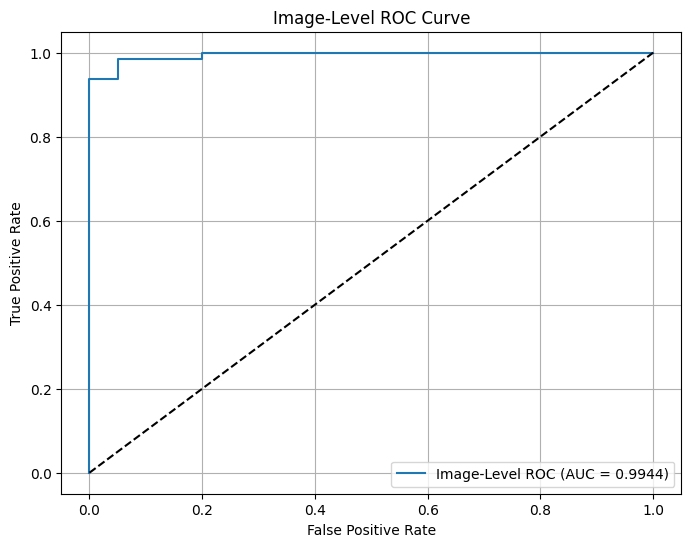

Final Metrics:
Image-level AUROC: 0.9944
Image-level Average Precision: 0.9983
Pixel-level AUROC: 0.6772
Pixel-level Average Precision: 0.3262


In [240]:
metrics = evaluate_model(model, test_loader_1, device)

print("Final Metrics:")
print(f"Image-level AUROC: {metrics['image_auroc']:.4f}")
print(f"Image-level Average Precision: {metrics['image_ap']:.4f}")
print(f"Pixel-level AUROC: {metrics['pixel_auroc']:.4f}")
print(f"Pixel-level Average Precision: {metrics['pixel_ap']:.4f}")